In [77]:
import math
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from PIL import Image
import scipy
from scipy import ndimage
%matplotlib inline
np.random.seed(1)

In [78]:
cifar_dataset_path='C:/Users/Pranav Nema/Desktop/Projects/Deep Learning/cifar-10-batches-py'

In [79]:
def load_cifar10_batch(cifar_dataset_path,batch_id):
    with open(cifar_dataset_path + '/data_batch_'+ str(batch_id), mode='rb') as file:
              # trying with Ncoding latin1
              batch = pickle.load(file,encoding='latin1')
    features = batch['data'].reshape(len(batch['data']),3,32,32).transpose(0,2,3,1)
    labels=np.array(batch['labels'])
    
    return features,labels

In [80]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [81]:
def display_stats(path,batch_id,sample_id):
    features, labels = load_cifar10_batch(path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))

In [82]:
batch_id=5
sample_id = 7000
display_stats(cifar_dataset_path,batch_id,sample_id)


Stats of batch #5:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 1014
Label Counts of [1](AUTOMOBILE) : 1014
Label Counts of [2](BIRD) : 952
Label Counts of [3](CAT) : 1016
Label Counts of [4](DEER) : 997
Label Counts of [5](DOG) : 1025
Label Counts of [6](FROG) : 980
Label Counts of [7](HORSE) : 977
Label Counts of [8](SHIP) : 1003
Label Counts of [9](TRUCK) : 1022

Example of Image 7000:
Image - Min Value: 21 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


In [54]:
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)]).T

In [55]:
def preprocess_data(features, labels):
    features=features/255.
    labels=one_hot(labels,10).T
    
    return features,labels

In [56]:
features,labels= load_cifar10_batch(cifar_dataset_path,2)
X_train,Y_train = preprocess_data(features, labels)

print("training input dataset is of shape: " + str(X_train.shape))
print("training label dataset is of shape: " + str(Y_train.shape))

training input dataset is of shape: (10000, 32, 32, 3)
training label dataset is of shape: (10000, 10)


In [57]:
print(X_train[50])

[[[0.13333333 0.20392157 0.15686275]
  [0.13333333 0.2        0.15294118]
  [0.1254902  0.19215686 0.14509804]
  ...
  [0.29411765 0.32941176 0.21568627]
  [0.28235294 0.31372549 0.20784314]
  [0.28627451 0.30588235 0.21960784]]

 [[0.18039216 0.23921569 0.16862745]
  [0.17254902 0.23529412 0.16470588]
  [0.16470588 0.22745098 0.15686275]
  ...
  [0.29019608 0.3254902  0.21960784]
  [0.2745098  0.30980392 0.20392157]
  [0.26666667 0.29803922 0.20784314]]

 [[0.26666667 0.31764706 0.23137255]
  [0.2627451  0.31372549 0.22352941]
  [0.24705882 0.29803922 0.20784314]
  ...
  [0.2745098  0.30588235 0.21176471]
  [0.25490196 0.28627451 0.19215686]
  [0.24313725 0.27843137 0.18431373]]

 ...

 [[0.29019608 0.36078431 0.26666667]
  [0.3254902  0.39607843 0.30196078]
  [0.34117647 0.41176471 0.31764706]
  ...
  [0.24705882 0.30588235 0.23137255]
  [0.2745098  0.32941176 0.25882353]
  [0.29019608 0.3254902  0.27058824]]

 [[0.2627451  0.3372549  0.24313725]
  [0.27058824 0.34901961 0.25490196]


In [58]:
def create_placeholders(n_H, n_W, n_C, n_y):
    X=tf.placeholder(tf.float32, shape= (None,n_H, n_W, n_C), name = "X")
    Y=tf.placeholder(tf.float32, shape = (None,n_y) , name = "Y")
    
    return X,Y

In [67]:
def init_params():
    W1=tf.get_variable("W1",[3,3,3,64],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2=tf.get_variable("W2",[3,3,64,128],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W3=tf.get_variable("W3",[4,4,128,256],initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W4=tf.get_variable("W4",[3,3,256,512], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    parameters={"W1":W1,"W2":W2,"W3":W3, "W4":W4}
    
    return parameters

### 1.2 - Forward propagation

In TensorFlow, there are built-in functions that carry out the convolution steps for you.

- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)

- **tf.nn.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

- **tf.contrib.layers.flatten(P)**: given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)

- **tf.contrib.layers.fully_connected(F, num_outputs):** given a the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)

In the last function above (`tf.contrib.layers.fully_connected`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters. 


In [68]:
def forward_propagation(X,parameters):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    W4 = parameters["W4"]
    
    #this is layer 1
    Z1 = tf.nn.conv2d(X,W1,strides = [1,1,1,1], padding="SAME")
    # activation for layer 1
    A1 = tf.nn.relu(Z1)
    #maxpool for layer 1 activation
    P1=tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = "SAME")
    #batch normalization for layer 1
    B1 = tf.layers.batch_normalization(P1)
    
    #this is layer 2
    Z2 = tf.nn.conv2d(B1, W2, strides = [1,1,1,1], padding = "SAME")
    #activation for layer 2
    A2 = tf.nn.relu(Z2)
     #maxpool for layer 2 activation
    P2=tf.nn.max_pool(A2, ksize=[1,6,6,1], strides = [1,6,6,1], padding = "SAME")
    #batch normalization for layer 2
    B2 = tf.layers.batch_normalization(P2)
    
    #this is layer 3
    Z3 = tf.nn.conv2d(B2, W3, strides = [1,1,1,1], padding = "SAME")
    #activation for layer 3
    A3 = tf.nn.relu(Z3)
     #maxpool for layer 3 activation
    P3=tf.nn.max_pool(A3, ksize=[1,4,4,1], strides = [1,4,4,1], padding = "SAME")
    #batch normalization for layer 3
    B3 = tf.layers.batch_normalization(P3)
    
    #this is layer 4
    Z4 = tf.nn.conv2d(B3, W4, strides = [1,1,1,1], padding = "SAME")
    #activation for layer 4
    A4 = tf.nn.relu(Z4)
     #maxpool for layer 3 activation
    P4=tf.nn.max_pool(A4, ksize=[1,4,4,1], strides = [1,4,4,1], padding = "SAME")
    #batch normalization for layer 3
    B4 = tf.layers.batch_normalization(P4)
    
    F5 = tf.contrib.layers.flatten(B4)
    #batch normalization for layer 4
    B5 = tf.layers.batch_normalization(F5)
    
    
    Z5 = tf.contrib.layers.fully_connected(B5, 10,activation_fn = None)
    
    return Z5
    

In [45]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = init_params()
    Z4 = forward_propagation(X, parameters)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z4, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z4 = " + str(a))

Z4 = [[ 0.5963085  -1.0310383  -1.9929036   0.7032484   0.36728734  0.12181246
  -0.1900527   1.2759746   1.0861664  -1.758242  ]
 [ 0.49846584 -0.9441631  -1.9418548   0.7999989   0.5412493  -0.21526346
  -0.2625127   1.0749451   1.106831   -1.6952434 ]]


In [69]:
def compute_cost(Z5,Y):
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z5,labels=Y))
    
    return cost


In [70]:
def load_test_batch():    
    with open(cifar_dataset_path + '/test_batch', mode='rb') as file:
                  # trying with Ncoding latin1
                  batch = pickle.load(file,encoding='latin1')
    features = batch['data'].reshape(len(batch['data']),3,32,32).transpose(0,2,3,1)
    labels=np.array(batch['labels'])

    return features, labels

In [93]:
features, labels = load_test_batch()
X_test,Y_test = preprocess_data(features, labels)

In [94]:
def random_mini_batches(X,Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]
    mini_batches = []
    np.random.seed(seed)
    
    # step 1:Shuffle X and Y
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :,:,:]
    shuffled_Y = Y[permutation, :]
    
    num_complete_minibatches= math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        
        mini_batch_X = shuffled_X[k*mini_batch_size:k*mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k*mini_batch_size:k*mini_batch_size + mini_batch_size,:]
        
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size:m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size:m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [95]:
def model(X_train, Y_train, X_test, Y_test,
          learning_rate = 0.009, num_epochs = 100,
          minibatch_size = 150 , print_cost = True):
    """
    Implements a four-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL-> FLATTEN -> FULLYCONNECTED
    
    """
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed=3
    (m, n_H, n_W, n_C)=X_train.shape
    n_Y= Y_train.shape[1]
   
    costs = []
    
    # initializing everything needed for running the session


 

    #     1. placeholders for X and Y
    X,Y=create_placeholders(n_H, n_W, n_C,n_Y)
    
    #     2.initialize parameters W1, W2, W3
    parameters= init_params()
    
    #     3. compute the forwar prop for these values once
    Z5=forward_propagation(X,parameters)
    
    #     4.compute the cost from the obtained Z4
    cost = compute_cost(Z5,Y)
    
    #     5. choosing an optimizer
    optimizer = tf.train.AdamOptimizer().minimize(cost)
  
    #     6.global variable initilized
    init = tf.global_variables_initializer()
    
    
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
                features,labels = load_cifar10_batch(cifar_dataset_path,epoch%5+1)
                X_train,Y_train = preprocess_data(features, labels)
                minibatch_cost = 0.
                num_minibatches = int(m/minibatch_size)
                seed=seed+1
                minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed) #need to implement random_mini_batches
                
                for minibatch in minibatches:
                    
                    (minibatch_X, minibatch_Y) = minibatch
                    
                    _ , temp_cost = sess.run([optimizer,cost], feed_dict = {X:minibatch_X, Y:minibatch_Y})
                    
                    minibatch_cost += temp_cost / num_minibatches
                    
                if print_cost == True and epoch %5 ==0:
                    print("Cost after epoch %i: %f" %(epoch,minibatch_cost))
                if print_cost == True and epoch % 1 == 0:
                    costs.append(minibatch_cost)
        
         # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations(per tens)')
        plt.title("Learning rate = "+str(learning_rate))
        plt.show()
        
        # Calculate the correct predictions
        predict_op = tf.argmax(Z5,1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y,1))
        
        # Calculate accuracy on the test set
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y:Y_train})
        test_accuracy = accuracy.eval({X:X_test, Y:Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        
        return train_accuracy, test_accuracy, parameters
    

Cost after epoch 0: 2.278493
Cost after epoch 5: 1.735792
Cost after epoch 10: 1.611680
Cost after epoch 15: 1.548569
Cost after epoch 20: 1.505792
Cost after epoch 25: 1.470116
Cost after epoch 30: 1.440269
Cost after epoch 35: 1.423790
Cost after epoch 40: 1.396061
Cost after epoch 45: 1.373207
Cost after epoch 50: 1.359072
Cost after epoch 55: 1.335066
Cost after epoch 60: 1.327017
Cost after epoch 65: 1.318056
Cost after epoch 70: 1.303249
Cost after epoch 75: 1.290341
Cost after epoch 80: 1.283232
Cost after epoch 85: 1.271781
Cost after epoch 90: 1.261452
Cost after epoch 95: 1.257280


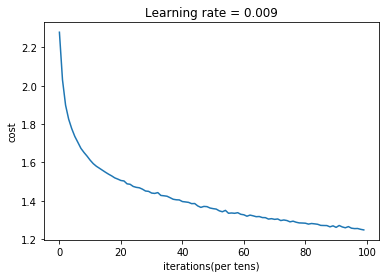

NameError: name 'Z3' is not defined

In [38]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test) # model run without batchnormalization, batch size =64 
# learning_rate = 0.009, num_epochs = 100

Cost after epoch 0: 2.304753
Cost after epoch 5: 1.665542
Cost after epoch 10: 1.545778
Cost after epoch 15: 1.456869
Cost after epoch 20: 1.377801
Cost after epoch 25: 1.319812
Cost after epoch 30: 1.270338
Cost after epoch 35: 1.231796
Cost after epoch 40: 1.188164
Cost after epoch 45: 1.153887
Cost after epoch 50: 1.130920
Cost after epoch 55: 1.098998
Cost after epoch 60: 1.078168
Cost after epoch 65: 1.054109
Cost after epoch 70: 1.032752
Cost after epoch 75: 1.012920
Cost after epoch 80: 0.992608
Cost after epoch 85: 0.972937
Cost after epoch 90: 0.966906
Cost after epoch 95: 0.945104


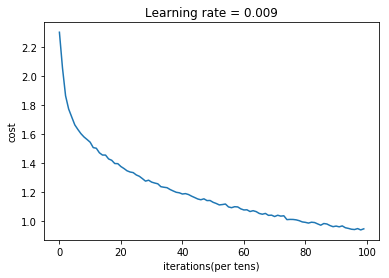

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.6823


NameError: name 'test_accuracy' is not defined

In [49]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test) # model run with batchnormalization, batch size =150
# learning_rate = 0.009, num_epochs = 100

Cost after epoch 0: 2.291982
Cost after epoch 5: 1.663958
Cost after epoch 10: 1.528001
Cost after epoch 15: 1.431306
Cost after epoch 20: 1.363509
Cost after epoch 25: 1.319430
Cost after epoch 30: 1.277431
Cost after epoch 35: 1.251543
Cost after epoch 40: 1.220004
Cost after epoch 45: 1.194422
Cost after epoch 50: 1.192769
Cost after epoch 55: 1.158833
Cost after epoch 60: 1.146256
Cost after epoch 65: 1.123563
Cost after epoch 70: 1.113322
Cost after epoch 75: 1.101071
Cost after epoch 80: 1.089923
Cost after epoch 85: 1.070504
Cost after epoch 90: 1.070236
Cost after epoch 95: 1.056487


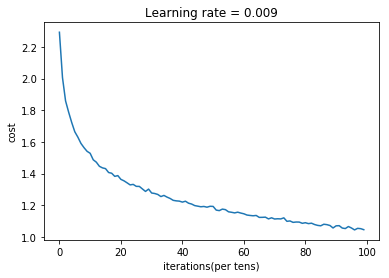

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.6466
Test Accuracy: 0.6466


In [66]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test) # model run with batchnormalization, batch size =150
# learning_rate = 0.009, num_epochs = 100 W1= 6x6, W2 = 4x4, W3 = 2x2, maxpooling layers also the same 

Cost after epoch 0: 2.127348
Cost after epoch 5: 1.475522
Cost after epoch 10: 1.182397
Cost after epoch 15: 0.940254
Cost after epoch 20: 0.718085
Cost after epoch 25: 0.496026
Cost after epoch 30: 0.380746
Cost after epoch 35: 0.288565
Cost after epoch 40: 0.108732
Cost after epoch 45: 0.067106
Cost after epoch 50: 0.005131
Cost after epoch 55: 0.002792
Cost after epoch 60: 0.001303
Cost after epoch 65: 0.000879
Cost after epoch 70: 0.000619
Cost after epoch 75: 0.000446
Cost after epoch 80: 0.000327
Cost after epoch 85: 0.000239
Cost after epoch 90: 0.000164
Cost after epoch 95: 0.000121


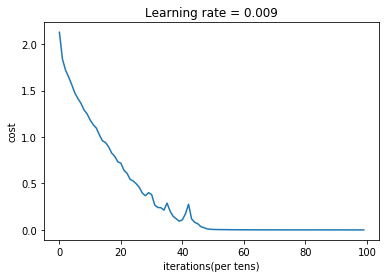

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 1.0


In [73]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test) # model run with batchnormalization, batch size =150
# num_epochs = 100 totaly different parameters, more filters, another layer, slower learning rate = 0.004

Cost after epoch 0: 2.127348
Cost after epoch 5: 1.475522
Cost after epoch 10: 1.182397
Cost after epoch 15: 0.940254
Cost after epoch 20: 0.718085
Cost after epoch 25: 0.496026
Cost after epoch 30: 0.380746
Cost after epoch 35: 0.288565


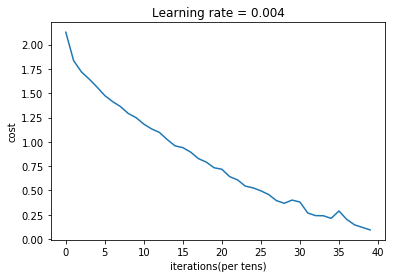

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9867
Test Accuracy: 0.9867


In [88]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test, learning_rate = 0.004 , num_epochs = 40) # model run with batchnormalization, batch size =150 
# num_epochs = 50 totaly different parameters, more filters, another layer, slower learning rate = 0.004
# using a new batch of cifar dataset for each epoch 

This one overfitts dramatically, trying it with all batches to see how increasing data does something, here using a variety of data, it still stops , it has bumbps all over, maybe regularization might help

Cost after epoch 0: 2.159791
Cost after epoch 5: 1.525712
Cost after epoch 10: 1.253495
Cost after epoch 15: 1.130843
Cost after epoch 20: 1.030131
Cost after epoch 25: 0.982303
Cost after epoch 30: 0.894730
Cost after epoch 35: 0.837079


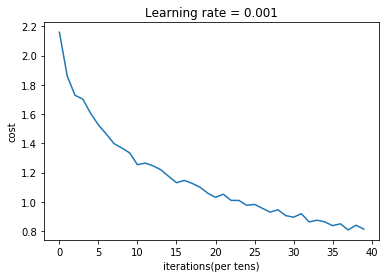

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.7605
Test Accuracy: 0.6796


In [98]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001 , num_epochs = 40) # model run with batchnormalization, batch size =150 
# num_epochs = 50 totaly different parameters, more filters, another layer, slower learning rate = 0.004
# using a new batch of cifar dataset for each epoch

Cost after epoch 0: 2.159791
Cost after epoch 5: 1.525712
Cost after epoch 10: 1.253495
Cost after epoch 15: 1.130843
Cost after epoch 20: 1.030131
Cost after epoch 25: 0.982303
Cost after epoch 30: 0.894730
Cost after epoch 35: 0.837079
Cost after epoch 40: 0.791891
Cost after epoch 45: 0.739929
Cost after epoch 50: 0.718401
Cost after epoch 55: 0.703880


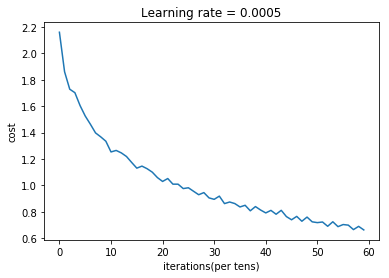

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.8227
Test Accuracy: 0.6981


In [99]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0005 , num_epochs = 60) # model run with batchnormalization, batch size =150 
# num_epochs = 60 totaly different parameters, more filters, another layer, slower learning rate = 0.005
# using a new batch of cifar dataset for each epoch